In [17]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
rgb_weights = [0.2989, 0.5870, 0.1140]
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img
            images.append(img)
    return images

In [181]:
root_dir_1 = 'CIFAR-10-images/train/airplane'
root_dir_2 = 'CIFAR-10-images/train/cat'
root_dir_3 = 'CIFAR-10-images/test/airplane'
root_dir_4 = 'CIFAR-10-images/test/cat'

In [182]:
# load train images
train_images_airplane = load_images_from_folder(root_dir_1)
train_images_cat = load_images_from_folder(root_dir_2)

In [183]:
# load test images
test_images_airplane = load_images_from_folder(root_dir_3)
test_images_cat = load_images_from_folder(root_dir_4)

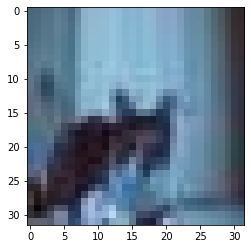

In [184]:
# display train images cat
plt.imshow(train_images_cat[1])
plt.show()

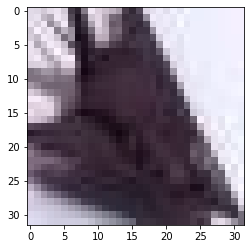

In [185]:
# display train images airplane
plt.imshow(train_images_airplane[1])
plt.show()

In [186]:
# data preprocessing 
train_images_cat = np.array(train_images_cat)
train_images_airplane = np.array(train_images_airplane)
test_images_cat = np.array(test_images_cat)
test_images_airplane = np.array(test_images_airplane)

# normalization
train_images_cat = np.divide(train_images_cat,255)
train_images_airplane = np.divide(train_images_airplane, 255)
test_images_cat = np.divide(test_images_cat, 255)
test_images_airplane = np.divide(test_images_airplane, 255)



# convertion into gray scale
rgb_weights = [0.2989, 0.5870, 0.1140]
train_images_cat = np.dot(train_images_cat, rgb_weights)
train_images_airplane = np.dot(train_images_airplane,rgb_weights)
test_images_cat = np.dot(test_images_cat, rgb_weights)
test_images_airplane = np.dot(test_images_airplane, rgb_weights)


In [187]:
# data is perfectly balanced
# reshape data
train_images_airplane = train_images_airplane.reshape(train_images_airplane.shape[0], -1)
train_images_cat = train_images_cat.reshape(train_images_cat.shape[0], -1)
test_images_airplane = test_images_airplane.reshape(test_images_airplane.shape[0], -1)
test_images_cat = test_images_cat.reshape(test_images_cat.shape[0], -1)

In [188]:
# output shapes
print('Airplane dataset shape: {}'.format(train_images_airplane.shape))
print('Cat dataset shape: {}'.format(train_images_cat.shape))

Airplane dataset shape: (5000, 1024)
Cat dataset shape: (5000, 1024)


In [189]:
# fitting a multivariate normal distribution without assuming independence among pixel values

from scipy.stats import multivariate_normal
def mean_func(X):
    
    return np.mean(X, axis = 0)

def sigma_func(X):
    cov = np.zeros((X.shape[1], X.shape[1]))
    mu = mean_func(X).reshape(1,-1)
    for items in X:
        items = items.reshape(1,-1)
        cov+=np.dot(items-mu,(items-mu).T)
    cov_act = cov/(X.shape[0]-1)
    # add regularizer params to covariance matrix
    alpha = 0.5
    cov_act +=np.diag(np.ones(X.shape[1])*alpha)
    return cov_act

def get_ccd(x, mu, cov):
    
    return multivariate_normal.logpdf(x,mu, cov)

def log_density_func(x, mu, det_sigma, inv_sigma):
    x = x.reshape(mu.shape[0],1)
    mu = mu.reshape(mu.shape[0],1)
    
    return -0.5*np.log(det_sigma) - 0.5* (np.dot((x - mu).T, np.dot(inv_sigma, x - mu)))

def get_posterior(prior, log_ccd):
    return np.log(prior) + log_ccd

def classifier(pos_0, pos_1):
    if pos_0>=pos_1:
        return 0
    else:
        return 1

In [190]:
# calculating parameters of the multivariate gaussian distribution for the airplane  and cat classes
# covariance matrix
cov_air = sigma_func(train_images_airplane)
cov_cat = sigma_func(train_images_cat)

# mean
mu_air = mean_func(train_images_airplane)
mu_cat = mean_func(train_images_cat)


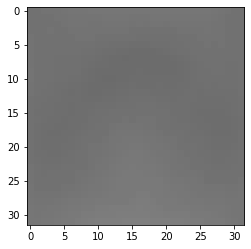

In [191]:
plt.imshow(mu_cat.reshape(32,32), cmap='gray', vmin=0, vmax=1)
plt.show()

In [192]:
# shapes of parameters
print(cov_air.shape)
print(cov_cat.shape)
print(mu_air.shape)
print(mu_cat.shape)

(1024, 1024)
(1024, 1024)
(1024,)
(1024,)


In [193]:
# estimating priors

# we obtain the priors from the training data distribution
p_air = train_images_airplane.shape[0]/(train_images_airplane.shape[0]+train_images_cat.shape[0])
p_cat = 1 - p_air


In [194]:
# estimating the class conditional desnities for all training samples

det_sigma_air = np.linalg.det(cov_air)
inv_sigma_air = np.linalg.pinv(cov_air)
det_sigma_cat = np.linalg.det(cov_cat)
inv_sigma_cat = np.linalg.pinv(cov_cat)

correct = 0
# testing for cat images
test_images = np.append(test_images_airplane, test_images_cat, axis = 0)
y_cat = np.ones((test_images_cat.shape[0]))
y_air = np.zeros((test_images_airplane.shape[0]))
y_images = np.append(y_air,y_cat)
pred_vector = np.zeros((y_images.shape[0]))
for i,items in enumerate(test_images):
    
    ccd_air = log_density_func(items, mu_air, det_sigma_air, inv_sigma_air)
    pos_air = get_posterior(p_air, ccd_air)
    
    ccd_cat = log_density_func(items, mu_cat, det_sigma_cat, inv_sigma_cat)
    pos_cat = get_posterior(p_cat, ccd_cat)
    out = classifier(pos_air, pos_cat)
    
    if out==y_images[i]:
        correct+=1
    pred_vector[i] = out
print('Accuracy of the gaussian modelling based classifier: {}%'.format(correct/len(test_images)*100))



Accuracy of the gaussian modelling based classifier: 64.64999999999999%


In [195]:
from sklearn.metrics import confusion_matrix
cf_mt = confusion_matrix(y_images, pred_vector)

<AxesSubplot:>

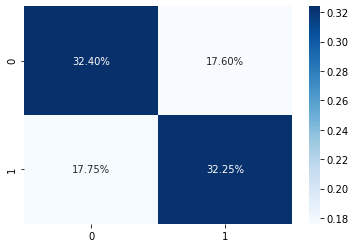

In [196]:
import seaborn as sns
sns.heatmap(cf_mt/np.sum(cf_mt), annot=True, 
            fmt='.2%', cmap='Blues')

In [197]:
# fitting an exponential distribution 

# parameters for exponential distribution
lambda_air = 1/mean_func(train_images_airplane)
lambda_cat = 1/mean_func(train_images_cat)

def log_expo_density(x, lambda_in):
    labmda_in = lambda_in.reshape(1,-1)
    x = x.reshape(1,-1)
    
    return np.sum(np.log(lambda_in) - np.multiply(x, lambda_in))



In [198]:
exp_c = 0
# class conditional densities
test_images = np.append(test_images_airplane, test_images_cat, axis = 0)
y_cat = np.ones((test_images_cat.shape[0]))
y_air = np.zeros((test_images_airplane.shape[0]))
y_images = np.append(y_air,y_cat)
pred_vector = np.zeros((y_images.shape[0]))
for i,items in enumerate(test_images):
    exp_ccd_air = log_expo_density(items, lambda_air)
    # print(exp_ccd_0.shape)
    
    exp_ccd_cat = log_expo_density(items, lambda_cat)
    pos_air = get_posterior(p_air, exp_ccd_air)
    pos_cat = get_posterior(p_cat, exp_ccd_cat)
    out = classifier(pos_air, pos_cat)
    if out==y_images[i]:
        exp_c+=1
    pred_vector[i] = out
print('Accuracy of a exponential based modelling classifier: {}%'.format(exp_c/len(test_images)*100))

Accuracy of a exponential based modelling classifier: 72.25%


In [199]:
cf_mt = confusion_matrix(y_images, pred_vector)

<AxesSubplot:>

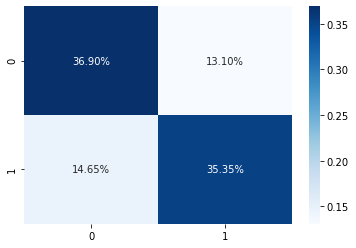

In [200]:
sns.heatmap(cf_mt/np.sum(cf_mt), annot=True, 
            fmt='.2%', cmap='Blues')